<h1><center> Welcome to step 1 and 2 of ML-MotEx </center></h1>

Use this script to generate a organized structure catalogue from a structural starting model, a fitting script and a dataset. This script does only handle Pair Distribution Function (PDF) data but ML-MotEx can in principle handle any data.

If you have already fitted the dataset with multiple structures or you have have another type of data than PDF please go on to the next script called "ML-MotEx-Step3+4.ipynb" which can help to run step 3+4 of ML-MotEx on all types of data.

![alt text](Algorithm_Step3_4.png.png "Step1+2")

Be aware that the output of the script (the organized structure catalogue with Rwp values) are set up as follows:

| ID | Rwp value | Number of atoms | Atom #1 | Atom #2 | ... | Atom #N |
|----|-----------|-----------------|---------|---------|-----|---------|
| 1  | 0.55      | 36              | 1       | 0       | ... | 1       |
| 2  | 0.23      | 23              | 0       | 1       | ... | 0       |

# First import modules, set seed parameters and import functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, random
from scipy.optimize.minpack import leastsq
from diffpy.Structure import Structure, Atom
from diffpy.srfit.pdf import PDFContribution, PDFParser, PDFGenerator
from diffpy.srfit.fitbase import FitRecipe, FitResults, Profile, FitContribution
from diffpy.srreal.pdfcalculator import DebyePDFCalculator
from multiprocessing import Pool
from functools import partial
from ase.io import read

random.seed(14)
np.random.seed(14)

ModuleNotFoundError: No module named 'diffpy.Structure'

In [2]:
def structure_catalogue_maker(Number_of_structures, Number_of_atoms, lower_atom_number, higher_atom_number):
    """This function makes a shuffled list containing 'Number_of_structures' number of lists which each is 
    'Number_of_atoms' long and is randomly distributed with 0's and 1's whereas the minimum number of 1's are 
    'lower_atom_number' and the maximum number of 1's are 'higher_atom_number'."""
    
    print ("Starting to make a structure catalogue with: ", str(Number_of_structures) + " structure from the starting model.")
    print ("The structure will have between " + str(lower_atom_number) + " and " + str(higher_atom_number) + " atoms")
    structure_catalogue = []
    for i in range(Number_of_structures):
        one_count = random.randint(lower_atom_number, higher_atom_number)
        zero_count = Number_of_atoms  - one_count
        my_list = [0]*zero_count + [1]*one_count
        random.shuffle(my_list)
        my_list.insert(0, one_count)
        structure_catalogue.append(my_list)
    print ("Permutations Succeeded")
    return structure_catalogue
    
def fitting(structure_catalogue, plot, index):
    """This function takes in a 'starting_model', and an 'index' from the 'structure_catalogue'. It generates the 
    corresponding structure and fit it to the 'Experimental_Data'."""
    
    # Read structure and divide it into two lists: Atoms we want to iterate (W) and atoms we do not iterate (O)
    stru = read(starting_model)
    xyz = stru.get_positions()
    xyz_W = xyz[:NumW].copy()
    xyz_O = xyz[NumW:len(xyz)].copy()
    keep_O = np.zeros(len(xyz_O))
    h = 0
    # Cycle through W atoms and delete W according to index 0's from permutation
    permutations = np.asarray(structure_catalogue)[:,1:]
    for j in range(len(xyz_W)):
        if permutations[index][j] == 0:
            xyz_W = np.delete(xyz_W,j - h,0)
            h = h+1   
    # Cycle through all atoms that is not iteratable and test if it is within the threshold distance. Delete atoms with no bonds
    for j in range(len(xyz_O)):        
        for k in range(len(xyz_W)):
            dist = np.linalg.norm(xyz_W[k] - xyz_O[j])
            if dist < threshold:    
                keep_O[j] = 1
                break
    h = 0            
    for j in range(len(xyz_O)):
        if keep_O[j] == 0:
            xyz_O = np.delete(xyz_O,j - h, 0)
            h += 1
            
    # Create structure for iterable (W) and non-iterable (O) atoms and combine them
    W_cluster = Structure([Atom('W', xi) for xi in xyz_W])
    O_cluster = Structure([Atom('O', xi) for xi in xyz_O])
    cluster = W_cluster + O_cluster
    
    # Make a standard cluster refinement using Diffpy-CMI
    # Import the data and make it a PDFprofile. Define the range of the data that will be used in the fit.
    pdfprofile = Profile()
    pdfparser = PDFParser()
    pdfparser.parseFile(Experimental_Data)
    pdfprofile.loadParsedData(pdfparser)
    pdfprofile.setCalculationRange(xmin = 1.6, xmax = 10)

    # Setup the PDFgenerator that calculates the PDF from the structure
    pdfgenerator_cluster = PDFGenerator("G")
    # Add the profile and both generators to the PDFcontribution
    pdfcontribution = FitContribution("pdf")
    pdfcontribution.setProfile(pdfprofile, xname="r") 
    pdfcontribution.addProfileGenerator(pdfgenerator_cluster)
    
    pdfgenerator_cluster.setQmin(0.7)
    pdfgenerator_cluster.setQmax(20)
    pdfgenerator_cluster._calc.evaluatortype = 'OPTIMIZED'
    pdfgenerator_cluster.setStructure(cluster, periodic = False)

    # Use scaling factors proportional to molar content
    pdfcontribution.setEquation('mc*G')

    # Define the recipe to do the fit and add it to the PDFcontribution
    recipe = FitRecipe()
    recipe.addContribution(pdfcontribution)

    # Avoid too much output during fitting 
    recipe.clearFitHooks()

    # Add the scale factor.
    recipe.addVar(pdfcontribution.mc, 1.0, tag = "scale")
    
    # Add the instrumental parameters to the two generators
    pdfgenerator_cluster.qdamp.value = 0.05
    pdfgenerator_cluster.qbroad.value = 0.01

    # Add the delta2 parameters, and make sure it cannot take unphysical values
    recipe.addVar(pdfgenerator_cluster.delta2, 0, name = "delta2_cluster", tag = "delta2")

    # Add ADP and "cell" for the cluster
    phase_cluster = pdfgenerator_cluster.phase
    atoms = phase_cluster.getScatterers()
    lat = phase_cluster.getLattice()

    recipe.newVar("zoomscale1", 1.0, tag = "lat")
    recipe.newVar("zoomscale2", 1.0, tag = "lat")
    recipe.newVar("zoomscale3", 1.0, tag = "lat")
    recipe.constrain(lat.a, 'zoomscale1')
    recipe.constrain(lat.b, 'zoomscale2')
    recipe.constrain(lat.c, 'zoomscale3')

    W_cluster = recipe.newVar("W_Biso_cluster1", 0.4, tag = 'adp_w')
    O_cluster = recipe.newVar("O_Biso_cluster1", 0.4, tag = 'adp_o')

    for atom in atoms:
        if atom.element.title() == "W":
            recipe.constrain(atom.Biso, W_cluster)
        elif atom.element.title() == "O":
            recipe.constrain(atom.Biso, O_cluster)

    recipe.restrain("zoomscale1", lb = 0.99, ub = 1.01, sig = 0.001)
    recipe.restrain("zoomscale2", lb = 0.99, ub = 1.01, sig = 0.001)
    recipe.restrain("zoomscale3", lb = 0.99, ub = 1.01, sig = 0.001)
    
    #free parameters are set
    recipe.fix('all')
    recipe.free("scale", "lat")

    # Turn off printout of iteration number.
    #recipe.clearFitHooks()

    # We can now execute the fit using scipy's least square optimizer.
    leastsq(recipe.residual, recipe.getValues())
    
    # We calculate the goodness-of-fit, Rwp
    g = recipe.pdf.profile.y
    gcalc = recipe.pdf.evaluate()
    rfactor1 = np.sqrt(sum((g - gcalc)**2) / sum((g)**2))
    
    # if plot == 1 it will also plot the fit
    if plot == 1:
        print ("FIT RESULTS\n")
        res1 = FitResults(recipe)
        print (res1)

        # Plot the observed and refined PDF.
        # Get the experimental data from the recipe
        r = recipe.pdf.profile.x
        gobs = recipe.pdf.profile.y

        # Get the calculated PDF and compute the difference between the calculated and measured PDF
        gcalc = recipe.pdf.evaluate()
        baseline = 1.1 * gobs.min()
        gdiff = gobs - gcalc

        # Plot!
        plt.figure()
        plt.plot(r, gobs, 'bo', label="G(r) data")
        plt.plot(r, gcalc, 'r-', label="G(r) fit")
        plt.plot(r, gdiff + baseline, 'g-', label="G(r) diff")
        plt.plot(r, np.zeros_like(r) + baseline, 'k:')
        plt.xlabel(r"$r (\AA)$")
        plt.ylabel(r"$G (\AA^{-2})$")
        plt.legend()

        plt.show()
    return rfactor1

def fitting_multiprocess(structure_catalogue, SaveName, cores=1):
    """This function runs the refinement of all the structures in the structure catalogue using multiprocessing"""
    start_time = time.time()
    values = []
    # Set up multiprocessing refinement
    fitindex = range(len(structure_catalogue))
    p = Pool(processes=cores)
    plot = 0
    func = partial(fitting, structure_catalogue, plot)
    results = p.map(func, fitindex)
    p.close()
    p.join()
    
    # Start refinement and append results to lists
    for i in fitindex:
        if i % 100 == 0:
            print ("I have now fitted: ", str(i) + " structures out of " + str(len(structure_catalogue)))
        rw = results[i]
        values.append(i)
        values.append(rw)
    values = np.reshape(values,(int(len(values)/2) , 2))
    
    # Save results in format that is suitable for Machine Learning
    print ("Best fit")
    print (values[np.argmin(values[:,1])])
    print("Total execution time: %.3fs" % (time.time()-start_time))
    Result = np.column_stack([values, np.asarray(structure_catalogue)[values[:,0].astype(int)]])
    np.savetxt(SaveName, Result)
    return Result



# Step 1: Produce a catalogue of structure motifs
### First define the starting model, how large the structure catalogue has to be, number of iterable atoms and threshold between iterable atoms and non-iterable atoms.

In [7]:
starting_model = "Structure_Models/109725.xyz" # Name of the starting model file
Number_of_structures = 10000 # Number of structures made to the structure catalogue
NumW = 24 # Number of atoms that should be permuted in the starting model
threshold = 2.5 # Thredshold for W - O bond


### Produce a catalogue of structure motifs

In [8]:
structure_catalogue = structure_catalogue_maker(Number_of_structures, Number_of_atoms=NumW, lower_atom_number=0, higher_atom_number=NumW)
print ("We show the first 10 structures in the catalogue:")
structure_catalogue[:10]


Starting to make a structure catalogue with:  100 structure from the starting model.
The structure will have between 0 and 24 atoms
Permutations Succeeded
We show the first 10 structures in the catalogue:


[[7, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [20, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [20, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
 [22, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [11, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
 [24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

# Step 2: Fit all of the structures from the catalogue of structure motifs to the dataset
### First define the experimental data path and the path you want the structure catalogue with fits to be saved

In [9]:
Experimental_Data = "DanMAX_AlphaKeggin.gr" # Name of the experimental file
saveFits = "Training_Data/structure_109725.txt" # Name of the saved fits file


### Produce organized structure catalogue with Rwp values

In [38]:
Result = fitting_multiprocess(structure_catalogue, SaveName=saveFits, cores=None)
print ("The best fitting structure is:")
Result[np.argmin(Result[:,1])]


I have now fitted:  0 structures out of 100
Best fit
[79.          0.54833363]
Total execution time: 10.271s
The best fitting structure is:


array([79.        ,  0.54833363, 21.        ,  1.        ,  0.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  0.        ,  1.        ,  1.        ,
        1.        ,  1.        ])


# Extra




### We can see that the best fitting structure has 21 atoms as also shown above. This is not the alpha-Keggin cluster which has 12 atoms. However, we can fit this structure to the experimental dataset:

FIT RESULTS

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       1045.40609599
Contributions  1035.71149847
Restraints     9.69459752
Chi2           1035.71149847
Reduced Chi2   1.23298988
Rw             0.54833362

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
mc          1.87805622e+00 +/- 3.82813272e-02
zoomscale1  9.89095996e-01 +/- 9.22196539e-04
zoomscale2  9.88889206e-01 +/- 9.23649396e-04
zoomscale3  9.87235320e-01 +/- 9.13645047e-04

Fixed Variables
------------------------------------------------------------------------------
O_Biso_cluster1  4.00000000e-01
W_Biso_cluster1  4.00000000e-01
delta2_cluster   0.00000000e+00

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
No correlati

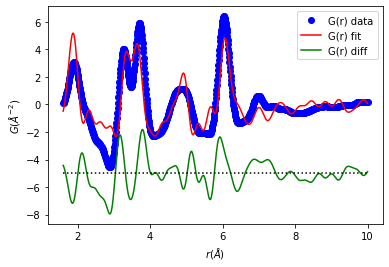

In [47]:
fitting(structure_catalogue, plot=1, index=np.argmin(Result[:,1]));

## We can compare the result with the result found using ML-MotEx in the script ML-MotEx-Step3+4

FIT RESULTS

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       787.00935220
Contributions  783.72495827
Restraints     3.28439394
Chi2           783.72495827
Reduced Chi2   0.93300590
Rw             0.47698784

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
mc          1.24411557e+00 +/- 2.41287982e-02
zoomscale1  9.89390417e-01 +/- 9.14606639e-04
zoomscale2  9.89390417e-01 +/- 9.14606638e-04
zoomscale3  9.88405893e-01 +/- 9.12011545e-04

Fixed Variables
------------------------------------------------------------------------------
O_Biso_cluster1  4.00000000e-01
W_Biso_cluster1  4.00000000e-01
delta2_cluster   0.00000000e+00

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
No correlations

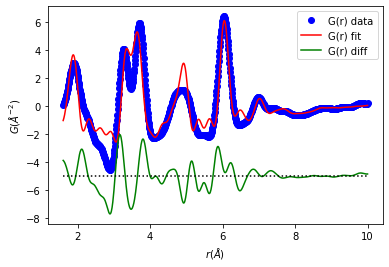

In [52]:
fitting([[12,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]], plot=1, index=0);

# We can also visualize the number of atoms vs. the Rwp value

In [2]:
plt.plot(Result[:,2], Result[:,1], "o")
plt.xlabel("Number of atoms")
plt.ylabel("Rwp value")
plt.show()

NameError: name 'plt' is not defined